# Navier-Stokes with a pivot-fixed falling flat plate 
## Using `Whirl` and `Dyn3d`

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

include(Pkg.dir("Dyn3d")*"/src/Dyn3d.jl")
using Dyn3d

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

## <span style="color:blue"> Set up rigid body with Dyn3d

In [3]:
include(Pkg.dir("Dyn3d")*"/src/config_files/2dLink.jl")

Config info set up.


#### Build joint-body chain

In [4]:
# build joint-body chain
bodys, joints, system = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bodys, joints, system)

#### Initialize rigid body system state

In [5]:
# init system
bd, soln = InitSystem!(bd)

# init soln structure
solns = (Soln)[]
push!(solns, soln)

# init VertsHistory struct
vs = []
push!(vs, VertsHistory(system.nbody, bd.bs));

This is a 2 body-joint system.
System is fixed in space


#### Set up HERKBody object

In [6]:
herkbody = Dyn3d.HERKBody(system.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
                (HERKFuncf,HERKFuncgti), (UpdatePosition!,UpdateVelocity!))

Order-3 HERK integrator.


#### Genrate body grid points and get linear velocity on them

In [7]:
# generate body points and fit it into 2d
# note: np = (# of points on 1d plate - 1)*4+1. So np=101 has 26 points
# and np=201 has 51 points, np=49 has 13 points

bgs = GenerateBodyGrid(bd; np=201)
bgs = CutOut2d(bd,bgs)
bgs = AcquireBodyGridKinematics(bd,bgs)

coord = hcat(bgs[1].q_i...)'[:,[1,2]]
motion = hcat(bgs[1].v_i...)'[:,[1,2]]
for i = 2:length(bgs)
    coord = [coord[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,2]]]
    motion = [motion[1:end-1,:]; hcat(bgs[i].v_i...)'[:,[1,2]]]
end

#### Variable containers for all stages in IFHERK and HERKBody

In [8]:
# Herk stages for both body and fluid solver
NS = 3

# Body kinematics container for ifherk input and herkbody output
bkins = Vector{Array{Float64,2}}(NS)

# Body force container for ifherk output(not integrated)
fs = Vector{Array{Float64,2}}(NS)

# Body force container for herkbody input(integrated)
f_exis = [zeros(bd.sys.nbody,6) for i=1:NS]

# All body info container
bds = [bd for i=1:NS];

#### Get body verts for plotting

In [9]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, solns[1].qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

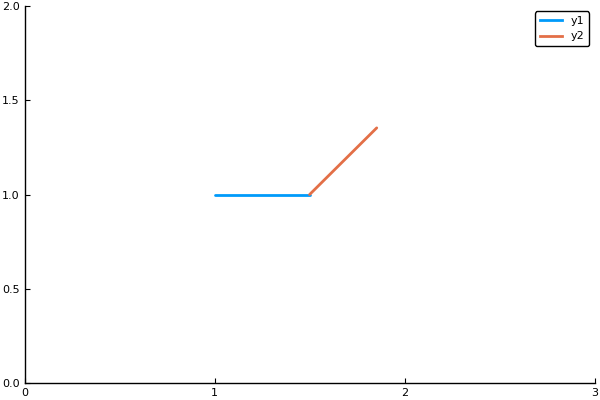

In [10]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,2:3,1], vs₀[i,2:3,2],linewidth=2)
end
plot!(xlims=(0,3), ylims=(0,2))

## <span style="color:blue"> Set up fluid solver with Whirl </span>

#### Set the flow parameters

In [11]:
Re = 200 # Reynolds number
U = 1.0 # Free stream velocity
U∞ = (U,0.0);

#### Set the domain size and time step size

In [12]:
nx = 152; ny = 102;
Ly = 2.0;
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re)
w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:3.0100000000000002, -0.01:0.02:2.0100000000000002)

#### Set up initial conditions

In [13]:
t = 0.0
w₀ .= 0.0
tf = 2*Δt
T = Δt:Δt:tf
fx = Float64[]
fy = Float64[]
thist = []
uhist = []
tsample = 0.02;

#### Get body points initial coordinates

In [14]:
bgs = AcquireBodyGridKinematics(bd,bgs)
coord = hcat(bgs[1].q_i...)'[:,[1,2]]
for i = 2:length(bgs)
    coord = [coord[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,2]]]
end
coord_init = coord;

#### Set up the Navier-Stokes  problem type

In [15]:
X̃ = VectorData(coord_init)
sys = Systems.NavierStokes((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, isstore = true, isstatic = false)

Navier-Stokes system on a grid of size 152 x 102

## <span style="color:blue"> Preparation for Time Marching </span>

#### Constants for coupling

In [16]:
tol = 5e-4
ω = (config_bodys[1].ρ)/(1.0+config_bodys[1].ρ)

0.5

#### Create Body solver object of type HerkBody

In [17]:
# construct body solver
herk = HERKBody(system.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
            (HERKFuncf,HERKFuncgti),
            (UpdatePosition!,UpdateVelocity!))

Order-3 HERK integrator.


#### Create Fluid solver object of type IFHERK

In [18]:
u = w₀
f = VectorData(X̃)
fs = [[f.u f.v] for i=1:NS]

# construct fluid solver with uniform constant free stream
ifherk_sc2d = Whirl.IFHERK_sc2d(u,f,sys.Δt,
                (t,u) -> Systems.plan_intfact(t,u,sys),
                (u,t,coord) -> Whirl.plan_constraints(u,t,sys,coord),
                ((u,t) -> Whirl.r₁(u,t,sys),
                 (u,t,motion) -> Whirl.r₂(u,t,sys,motion)),
                coord_init,
                tol=1e-3,rk=Whirl.TimeMarching.RK31,
                isstored=true,isstaticconstraints=false)

Order-3 IF-HERK for fs interaction integrator with
   State of type Whirl.Fields.Nodes{Whirl.Fields.Dual,152,102}
   Force of type Whirl.Fields.VectorData{101}
   Time step size 0.01


## <span style="color:blue"> Time Marching! </span>

#### Make timestep in Dyn3d and Whirl the same

In [19]:
soln.dt = Δt
solns[1].dt = soln.dt

# total number of body points in the fluid solver
np_total = round(Int,length(f)/2)

101

In [20]:
@time for t in T

    iter = 1
    fᵢ = fs.*Δx^2

    # record body info
    soln_buffer = deepcopy(soln)
    bd_buffer = deepcopy(bd)
    bgs_buffer = deepcopy(bgs)

    # record fluid info
    u_buffer = deepcopy(u)
    t_buffer = t

    while true

        #--------------------------------------------------------
        # get body state of the last timestep
        soln = deepcopy(soln_buffer)
        bd = deepcopy(bd_buffer)
        bgs = deepcopy(bgs_buffer)

        #--------------------------------------------------------
        # integrate body forces from body points
        for k = 1:NS
            # assign fluid body points forces to bgs to integrate
            b_cnt = 1
            ref = 0
            for i = 1:np_total
                # move to the next bgs if i exceed bgs[b_cnt].np
                if i > ref + bgs[b_cnt].np
                    ref += bgs[b_cnt].np
                    b_cnt += 1        
                end
                bgs[b_cnt].f_ex3d[i-ref][[1,2]] = fᵢ[k][i,:]
            end

            # integrate total forces from all body points on a body
            bgs = IntegrateBodyGridDynamics(bd,bgs)
            for i = 1:bd.sys.nbody
                f_exis[k][i,:] = bgs[i].f_ex6d
            end
        end
        
        #--------------------------------------------------------
        # advance body solver for one step        
        bd = bds[NS]
        soln, bds = herkbody(soln, bd; _isfixedstep=true, _outputmode=true, f_exi=f_exis);

        #--------------------------------------------------------
        # acquire vel and coord of body points for fluid computation
        for k = 1:NS
            bgs = AcquireBodyGridKinematics(bds[k],bgs)
            coord = hcat(bgs[1].q_i...)'[:,[1,2]]
            motion = hcat(bgs[1].v_i...)'[:,[1,2]]
            for i = 2:length(bgs)
                coord = [coord[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,2]]]
                motion = [motion[1:end-1,:]; hcat(bgs[i].v_i...)'[:,[1,2]]]
            end
            bkins[k] = [coord motion]
        end
        
        #--------------------------------------------------------
        # get fluid state of the last timestep
        u = deepcopy(u_buffer)
        t = t_buffer

        #--------------------------------------------------------
        # advance fluid solver for one step
        t, u, f, fs = ifherk_sc2d(t,u,bkins)

        #--------------------------------------------------------
        # check if converge, use relaxation if not
        ϵ = abs(sum(fs[NS]*Δx^2 - fᵢ[NS]))

        if ϵ < tol break end

        println("proposed fy at all stage: ", sum(fᵢ[1][:,2])," ", sum(fᵢ[2][:,2])," ", sum(fᵢ[3][:,2]))
        println("corrected fy at all stage: ", sum(fs[1][:,2])*Δx^2," ", sum(fs[2][:,2])*Δx^2," ", sum(fs[3][:,2])*Δx^2)
        
        # if not converge, use relaxation
        fᵢ = (1-ω)*fᵢ + ω*fs*Δx^2
        
        println("relaxation fy at all stage: ", sum(fᵢ[1][:,2])," ", sum(fᵢ[2][:,2])," ", sum(fᵢ[3][:,2]),"\n")
        println("iteration ",iter,", ϵ = ",ϵ);
        iter += 1
        
    end
    # converged for this timestep
    print("time = ", t-Δt, " converged through ", iter, " iterations\n")
    
    # record body info
    push!(solns, soln)
    push!(vs, VertsHistory(system.nbody, bd.bs))

    # record fluid info
    push!(thist,t)
    push!(fx,sum(fᵢ[NS][:,1]))
    push!(fy,sum(fᵢ[NS][:,2]))
    push!(uhist,deepcopy(u))
    
end

println("solution completed through time t = ",t)

proposed fy at all stage: 0.0 0.0 0.0
corrected fy at all stage: -51.94153584792282 8.85524050342671 24.49027609788738
relaxation fy at all stage: -25.97076792396122 4.427620251713455 12.245138054498845

iteration 1, ϵ = 4.30636159516871
proposed fy at all stage: -25.97076792396122 4.427620251713455 12.245138054498845
corrected fy at all stage: -52.71162136248944 232.75219003338754 245.62861496405262
relaxation fy at all stage: -39.34119463190734 118.58990514254967 128.9368765070957

iteration 2, ϵ = 144.55736883031204
proposed fy at all stage: -39.34119463190734 118.58990514254967 128.9368765070957
corrected fy at all stage: -54.443799876273125 377.8540280622124 1515.613645746812
relaxation fy at all stage: -46.89249725372069 248.22196660238242 822.2752611248668

iteration 3, ϵ = 1120.6269238479435
proposed fy at all stage: -46.89249725372069 248.22196660238242 822.2752611248668
corrected fy at all stage: -50.529029968318305 411.15053236416674 1537.6066480199042
relaxation fy at all s

LoadError: [91mInterruptException:[39m

## <span style="color:blue"> Plot </span>

#### Get body verts history

In [21]:
@get bd (bs, js, sys)

# get verts info based on this regular grid solution
vshist = []
for i = 1:length(solns)
    bs, js, sys = UpdatePosition!(bs, js, sys, solns[i].qJ)
    push!(vshist, VertsHistory(sys.nbody, bs))
end

#### Plot first and last time field

In [22]:
p1 = plot(xg,yg,uhist[1],levels=linspace(-0.2,0.2,30))
for i = 1:sys.nbody
    plot!(p1,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="grey")
end
p1

LoadError: [91mBoundsError: attempt to access 0-element Array{Any,1} at index [1][39m

In [23]:
p2 = plot(xg,yg,uhist[end],levels=linspace(-0.2,0.2,30))
for i = 1:sys.nbody
    plot!(p2,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="grey")
end
p2

LoadError: [91mBoundsError: attempt to access 0-element Array{Any,1} at index [0][39m

#### Body position begining and end

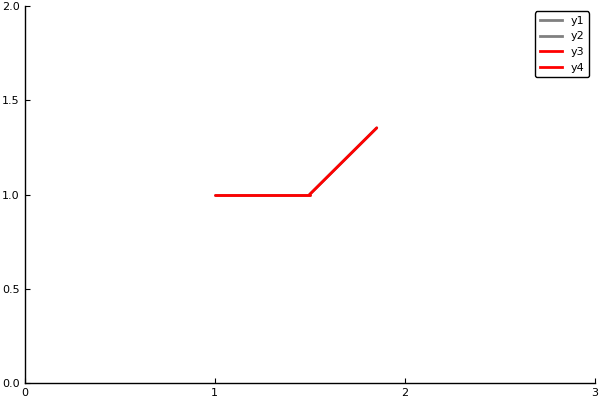

In [24]:
pb = plot()
for i = 1:sys.nbody
    plot!(pb,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="grey")
end
for i = 1:sys.nbody
    plot!(pb,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="red")
end
plot!(pb,xlims=(0,3), ylims=(0,2))
pb

#### Gif!

In [25]:
@gif for j = 1:length(uhist)
    plot(xg,yg,uhist[j],levels=linspace(-0.2,0.2,30))
    for i = 1:sys.nbody
        plot!(vshist[j][i,2:3,1], vshist[j][i,2:3,2],linewidth=2,linecolor="grey")
    end
end

LoadError: [91mfailed process: Process(`ffmpeg -v 0 -i /tmp/tmpWZGCOz/%06d.png -vf palettegen=stats_mode=diff -y /tmp/tmpWZGCOz/palette.bmp`, ProcessExited(1)) [1][39m

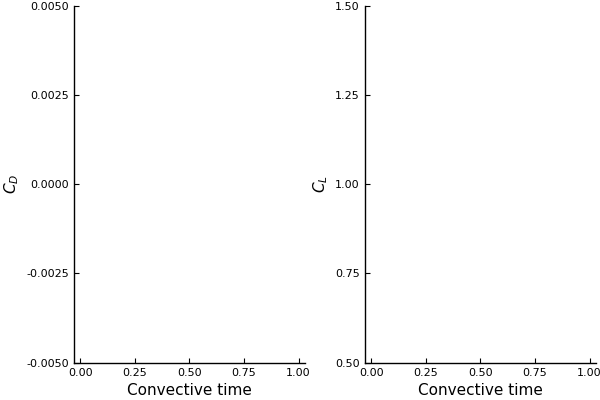

In [26]:
px = plot(thist,2*fx,ylim=(-0.005,0.005),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(0.5,1.5),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

In [27]:
fx

0-element Array{Float64,1}

In [28]:
fy

0-element Array{Float64,1}